In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io
import os.path, time

In [40]:
expdir='Y:\\user\\tdanko\\Imaging\\1_ECM\\Live Culture\\Cytation_biospa\\20190311_TNR550_Bic\\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\\190311_211649_Plate 1\\\\'

In [41]:
results={"filename":[],
         "exp name":[],
        "condition":[],
        "namestem before channel":[],
         "namestem after channel":[],
        "timepoint":[],
        "analyse":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("montage" in str(filelist[i]))==False:
        
        if filelist[i].endswith(".tif"): 
            results["filename"].append(filelist[i])
            results["analyse"].append(False)
            results["exp name"].append(filelist[i][:-12].split('\\')[-2])
            results["namestem before channel"].append('\\'.join(filelist[i].split('\\')[:-1])+'\\'+'_'.join(filelist[i].split('\\')[-1].split('_')[:-4]))
            results["namestem after channel"].append('_'.join(filelist[i].split('\\')[-1].split('_')[-3:-1]))
            results["timepoint"].append(filelist[i][-7:-4])
            if len(fnmatch.filter([filelist[i]],r'*A[0-9]_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*B[0-9]_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],r'*C[0-9]_*'))>0:
                results["condition"].append("Blocked + Bic")
            
            elif len(fnmatch.filter([filelist[i]],r'*D1_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D2_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D3_*'))>0:
                results["condition"].append("Unblocked")
            
            elif len(fnmatch.filter([filelist[i]],r'*D4_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*D5_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],r'*D6_*'))>0:
                results["condition"].append("Blocked")
            else:
                results["condition"].append('Unspecified')

In [42]:
df=pd.DataFrame(results)

In [43]:
df["condition"].unique()

array(['Unblocked', 'Blocked', 'Blocked + Bic'], dtype=object)

## Throw out images with no cells

In [44]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index

In [45]:
len(indexes)

384

In [46]:
import ipywidgets as widgets
from ipywidgets import interact



#load first image

ecm_image_name=df["filename"][indexes[0]]
ecm_image = io.imread(ecm_image_name)


def f(Threshold,Image_no):
    
    ii=Image_no
    ecm_image_name=df["filename"][indexes[ii]]
    ecm_image = io.imread(ecm_image_name)

    if Threshold=="Keep":
        df["analyse"][indexes[ii]]=True
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(ecm_image,cmap='gray')
    plt.title(ecm_image_name)
    

#widgets
Threshold=widgets.Dropdown(options=["Keep","Toss"])
Image_no=widgets.IntText(min=0,max=len(indexes),value=0)

w=interact(f,Threshold=Threshold,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Keep', 'Toss'), value='Keep'), IntText(value=0, description='Image_no'), Output()), _dom_classes=('widget-interact',))

In [47]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index
timepoints=df["timepoint"].unique()

intensities={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
counter=0
for i in indexes:
    counter+=1
    print(str(counter)+' out of ' +str(len(indexes)))
    name=df["filename"][i]
    print(name)
    namestem='\\'.join(name.split('\\')[:-1])+'\\'+'_'.join(name.split('\\')[-1].split('_')[:-4])+'_2_'+name.split('_')[-3]+'_RFP_'
    print(namestem)
    intensities["namestem"].append(namestem)
    intensities["condition"].append(df["condition"][i])
    intensities_vect=[]
    intensities_vect_bgsubtracted=[]
    if df["analyse"][i]==True:
        for time in timepoints:
            print(time)
            fullname=namestem+time+'.tif'
            #read image
            ecm_image = io.imread(fullname)
            intensities_vect.append(ecm_image.mean())
            #bg
            bg=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
            ecm_bgreduced=np.subtract(ecm_image,bg)
            ecm_bgreduced[ecm_bgreduced<0]=0
            intensities_vect_bgsubtracted.append(ecm_bgreduced.mean())
        intensities["intensities vector"].append(intensities_vect)
        intensities["intensities vector bgsub"].append(intensities_vect_bgsubtracted)
    else:
        intensities["intensities vector"].append(np.nan)
        intensities["intensities vector bgsub"].append(np.nan) 

1 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
2 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
3 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
20 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A2_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
21 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A2_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
22 out of 384
Y:\user\tdanko\Imaging\1_E

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
39 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A3_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A3_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
40 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A3_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A3_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
41 out of 384
Y:\user\tdanko\Imaging\1_ECM

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
58 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A4_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A4_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
59 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A4_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A4_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
60 out of 384
Y:\user\tdanko\Imaging\1_ECM\L

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
77 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A5_02_1_6_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A5_02_2_6_RFP_
78 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A5_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\A5_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
79 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_T

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
97 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B1_02_2_10_RFP_
98 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B1_02_2_11_RFP_
99 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B1_02_1_12_Phas

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
116 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B2_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
117 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B2_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
118 out of 384
Y:\user\tdanko\Imaging\

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
136 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B3_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B3_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
137 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B3_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B3_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
138 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
155 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B4_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B4_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
156 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B4_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B4_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
157 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
175 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B5_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B5_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
176 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B5_02_1_9_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\B5_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
177 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
196 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C1_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C1_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
197 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C1_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C1_02_2_13_RFP_
198 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_201

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
216 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C2_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C2_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
217 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C2_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C2_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
218 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
235 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C3_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C3_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
236 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C3_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C3_02_2_5_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
237 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
254 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C4_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C4_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
255 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C4_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C4_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
256 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
273 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C6_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C6_02_2_10_RFP_
274 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C6_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\C6_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
275 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_201

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
292 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D1_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D1_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
293 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D1_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D1_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
294 out of 384
Y:\user\tdanko\Imaging\

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
311 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D2_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D2_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
312 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D2_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D2_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
313 out of 384
Y:\user\tdanko\Imaging\1_

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
330 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D3_02_1_3_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D3_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
331 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D3_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D3_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
332 out of 384
Y:\user\tdanko\Imaging\1_EC

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
354 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D5_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D5_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
355 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D5_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D5_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
356 out of 384
Y:\user\tdanko\Imaging\

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
375 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D6_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D6_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
376 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D6_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190311_TNR550_Bic\190311_211649_20190306_Tal_TNR550_11-Mar-2019 19-13-07\190311_211649_Plate 1\D6_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
377 out of 384
Y:\user\tdanko\Imaging\1_

In [48]:
for key in intensities.keys():
    print(key)
    print(len(intensities[key]))

namestem
384
condition
384
intensities vector
384
intensities vector bgsub
384


In [59]:
dfint=pd.DataFrame(intensities)

In [50]:
dfint.columns

Index(['namestem', 'condition', 'intensities vector',
       'intensities vector bgsub'],
      dtype='object')

In [61]:
for i in range(0,len(dfint)):
    if type(dfint["intensities vector bgsub"][i])==float:
        #print('true')
        dfint["intensities vector"][i]=np.repeat(np.nan,18)
        dfint["intensities vector bgsub"][i]=np.repeat(np.nan,18)

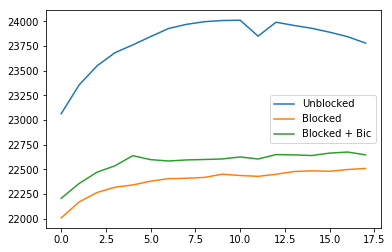

In [62]:
toplot="intensities vector"
conditioni=dfint["condition"].unique()
for condition in dfint["condition"].unique():
    
    df2plot=dfint[dfint["condition"]==condition]
    plt.plot(np.nanmean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)

In [65]:
dfint.to_pickle(expdir+'20191003_longterm_intensitiespart1.pkl')

,namestem,condition,intensities vector,intensities vector bgsub
0,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[24936.381563060328, 25268.434852905026, 25457...","[699.206482083908, 801.1757887708451, 857.7432..."
1,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[23218.804783749783, 23489.987131449187, 23577...","[596.7737754853064, 651.142309868201, 679.3445..."
2,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[22873.116685464745, 23085.212289063857, 23326...","[738.2547455971594, 877.7465862195139, 988.793..."
3,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[29110.411144730755, 29813.761071888195, 30232...","[615.2175610698453, 626.7671905123385, 641.317..."
4,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[26466.283303328706, 26866.992987774018, 27132...","[627.6419879422034, 689.0528993951522, 748.751..."
5,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[25000.32147879432, 25266.32313899011, 25460.9...","[627.3234539456543, 683.5067254030275, 726.096..."
6,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[23953.761508401294, 24127.715796532477, 24251...","[520.6460071886444, 549.7811691893364, 566.102..."
7,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[25167.96780467349, 25405.024664345827, 25686....","[529.5792210479565, 529.2665616704695, 543.230..."
8,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[23009.09269351177, 23156.90774029007, 23248.2...","[517.1258883616683, 538.7565404198274, 558.628..."
9,Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cyta...,Unblocked,"[21250.47362755943, 21250.811110026607, 21257....","[484.27986300292565, 491.3874274931159, 491.99..."


In [21]:
intensities_concat={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
for i in range(0,len(dfintearly)):
    stemearly=dfintearly["namestem"][i].split('\\')[-1]
    intensities_concat["namestem"].append(stemearly)
    
    intensities_concat["condition"].append(dfintearly[dfintearly["namestem"].str.contains(stemearly)]["condition"].values[0])
    
    a=dfintearly[dfintearly["namestem"].str.contains(stemearly)]["intensities vector"].values[0]
    b=dfint[dfint["namestem"].str.contains(stemearly)]["intensities vector"].values[0]
    intensities_concat["intensities vector"].append(a+b)
    
    a=dfintearly[dfintearly["namestem"].str.contains(stemearly)]["intensities vector bgsub"].values[0]
    b=dfint[dfint["namestem"].str.contains(stemearly)]["intensities vector bgsub"].values[0]
    intensities_concat["intensities vector bgsub"].append(a+b)

In [22]:
dfincon=pd.DataFrame(intensities_concat)

In [23]:
dfincon["condition"].unique()

array(['Unblocked', 'Blocked', 'Blocked + Bic'], dtype=object)

In [24]:
toplot="intensities vector"
conditioni=dfincon["condition"].unique()
for condition in dfincon["condition"].unique():
    
    df2plot=dfincon[dfincon["condition"]==condition]
    plt.plot(np.mean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)

ValueError: operands could not be broadcast together with shapes (3312,) (24,) 

In [162]:
dfincon["condition"].unique()

array(['Unblocked'], dtype=object)

In [190]:
dfincon.to_pickle(expdir+'longterm_intensities_twofoldersconcatenated.pkl')